# Trabajo en Case 1

## Teoría
#### 1. Indique cual es costo de "Training" y de test del algoritmo KNN.
R/ El costo de entrenar es O(1), ya que es solo la carga de datos. El costo de entrenamiento es de O(N*D), donde N es la cantidad de datos, mientras que D son los features. En el peor caso donde N = D, este tendría un costo de O(N^2)

#### 2. Explique por qué se dice que instance learning es un algoritmo por fuerza bruta o perezoso.
R/ Este modelo solo se basa en comparación del dato a etiquetar con los N datos cargados en memoria, no existe un modelo que haga una simplificación, sólo comparaciones para aproximar el dato.

#### 3. Indique cuántas comparaciones se deben realizar en la etapa de test (asumiendo el peor de los casos).
R/ N*D pruebas, donde N es la cantidad de datos, mientras que D son los features. En el peor caso donde N = D, este tendria que hacer N^2 comparaciones

#### 4. Investigue alguna modificación que se ha realizado al algoritmo original del KNN.
R/ Una variante del algoritmo es el árbol KD, el cual consiste en mejorar la eficiencia de encontrar los k-vecinos más cercanos al indexar los ejemplos de entrenamiento en una estructura de árbol binario, donde en cada nivel del árbol el algoritmo selecciona una característica y divide los ejemplos de entrenamiento en dos subárboles según el valor medio de esa característica.


In [1]:
import numpy as np
import sys
import time

In [2]:
class KNearestNeighbors():
    def __init__(self, X_train, y_train, n_classes, n_neighbors=5, weights='uniform'):

        self.X_train = X_train
        self.y_train = y_train

        self.n_neighbors = n_neighbors
        self.weights = weights

        self.n_classes = n_classes

    def euclidian_distance(self, a, b):
        return np.sqrt(np.sum((a - b)**2, axis=1))

    def kneighbors(self, X_test, return_distance=False):

        dist = []
        neigh_ind = []
        point_dist = []
        
        for x_test in X_test:
            point_dist += [ self.euclidian_distance(x_test, self.X_train) ]

        for row in point_dist:
            enum_neigh = enumerate(row)
            sorted_neigh = sorted(enum_neigh,
                                  key=lambda x: x[1])[:self.n_neighbors]

            ind_list = [tup[0] for tup in sorted_neigh]
            dist_list = [tup[1] for tup in sorted_neigh]

            dist.append(dist_list)
            neigh_ind.append(ind_list)

        if return_distance:
            return np.array(dist), np.array(neigh_ind)

        return np.array(neigh_ind)

    def predict(self, X_test):

        start_time = time.time()
        if self.weights == 'uniform':
            neighbors = self.kneighbors(X_test)
            y_pred = np.array([
                np.argmax(np.bincount(self.y_train[neighbor]))
                for neighbor in neighbors
            ])
            return y_pred, time.time() - start_time

        if self.weights == 'distance':
            dists, neighbors = self.kneighbors(X_test, return_distance=True)
            y_results = []
            y_pred = []
            
            for i, neighbor in enumerate(neighbors):
                y_results += [(self.y_train[neighbor], dists[i])]
                
            for y_tag, dist in y_results:
                y_class_dist = []
                for j in range(self.n_classes):
                    dist_array = np.where(y_tag == j, dist, 0)
                    if np.count_nonzero(dist_array) == 0:
                        mean_dist = sys.maxsize
                    else:
                        mean_dist = np.sum(dist_array) / np.count_nonzero(dist_array)
                    y_class_dist.append(mean_dist)
                y_pred.append(np.argmin(y_class_dist))

            return np.array(y_pred), time.time() - start_time

    def score(self, X_test, y_test):
        y_pred, time = self.predict(X_test)
        return float(sum(y_pred == y_test)) / float(len(y_test)), y_pred, y_test, time


# Iris dataset (Observations/Treatments)

In [17]:
import sklearn.datasets as datasets
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
from matplotlib import pyplot as plt
dataset = datasets.load_iris(as_frame=True)

X = dataset.data
y = dataset.target


In [18]:
mu = np.mean(X, 0)
sigma = np.std(X, 0)
X = (X - mu ) / sigma

X.head(10)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,-0.900681,1.019004,-1.340227,-1.315444
1,-1.143017,-0.131979,-1.340227,-1.315444
2,-1.385353,0.328414,-1.397064,-1.315444
3,-1.506521,0.098217,-1.283389,-1.315444
4,-1.021849,1.249201,-1.340227,-1.315444
5,-0.537178,1.939791,-1.169714,-1.052180
6,-1.506521,0.788808,-1.340227,-1.183812
7,-1.021849,0.788808,-1.283389,-1.315444
8,-1.748856,-0.362176,-1.340227,-1.315444
9,-1.143017,0.098217,-1.283389,-1.447076


In [5]:
k_values = [2,3,5,7,8,10,11]

if isinstance(X, pd.DataFrame):
    X = X.to_numpy()
    y = y.to_numpy()

X_train, X_test, y_train, y_test = train_test_split(\
                X, y, test_size=0.25, random_state=45)


accuracy_values = []

for i in k_values:

    uniform_classifier = KNearestNeighbors(X_train, y_train, 3, n_neighbors=i)
    distance_classifier = KNearestNeighbors(X_train, y_train, 3, n_neighbors=i, weights='distance')
    sklearn_classifier = KNeighborsClassifier(n_neighbors=i).fit(X_train, y_train)
    
    uniform_accuracy = uniform_classifier.score(X_test, y_test)[0]
    distance_accuracy = distance_classifier.score(X_test, y_test)[0]
    uniform_time = uniform_classifier.score(X_test, y_test)[3]
    distance_time = distance_classifier.score(X_test, y_test)[3]
    sklearn_accuracy = sklearn_classifier.score(X_test, y_test)

    accuracy_values.append([uniform_accuracy, uniform_time, distance_accuracy, distance_time, sklearn_accuracy])
    
pd.DataFrame(accuracy_values,
             [("K="+ str(k)) for k in k_values],    
             ['Accuracy (uniform)', 'Time (uniform)', 'Accuracy (distance)', 'Time (distance)', 'Accuracy (Sklearn)'])

,Accuracy (uniform),Time (uniform),Accuracy (distance),Time (distance),Accuracy (Sklearn)
K=2,0.894737,0.001196,0.947368,0.002481,0.894737
K=3,0.947368,0.001821,0.894737,0.001687,0.947368
K=5,0.947368,0.001503,0.868421,0.002425,0.947368
K=7,0.921053,0.001110,0.921053,0.001729,0.921053
K=8,0.947368,0.001122,0.921053,0.001746,0.947368
K=10,0.947368,0.001127,0.868421,0.001766,0.947368
K=11,0.947368,0.001155,0.894737,0.001766,0.947368


### Resultados
Los resultados de la clasificacion de las imagenes indican para los valores de K solicitados, la implementación de distancia propia tiene peores resultados que los de la biblioteca SKlearn, mientras que la uniforme arroja los mismos resultados que los de la biblioteca. Por otro lado, el tiempo que le toma a la implementacion uniforme tiende a ser menor que la implementacion de distancia por casi 1 segundo. Tomando en cuenta esto, ademas de lo mencionado anteriormente hace que para estos valores de K, la implementacion uniforme sea la mejor opcion.

In [6]:
accuracy_values = []

for i in range(2, 100): 
    uniform_classifier = KNearestNeighbors(X_train, y_train, 3, n_neighbors=i)
    distance_classifier = KNearestNeighbors(X_train, y_train, 3, n_neighbors=i, weights='distance')
    sklearn_classifier = KNeighborsClassifier(n_neighbors=i).fit(X_train, y_train)
    
    uniform_accuracy = uniform_classifier.score(X_test, y_test)[0]
    distance_accuracy = distance_classifier.score(X_test, y_test)[0]
    sklearn_accuracy = sklearn_classifier.score(X_test, y_test)

    accuracy_values.append([uniform_accuracy, distance_accuracy, sklearn_accuracy])

uniform_acc = [acc[0] for acc in accuracy_values]
distance_acc = [acc[1] for acc in accuracy_values]
sk_acc = [acc[2] for acc in accuracy_values]

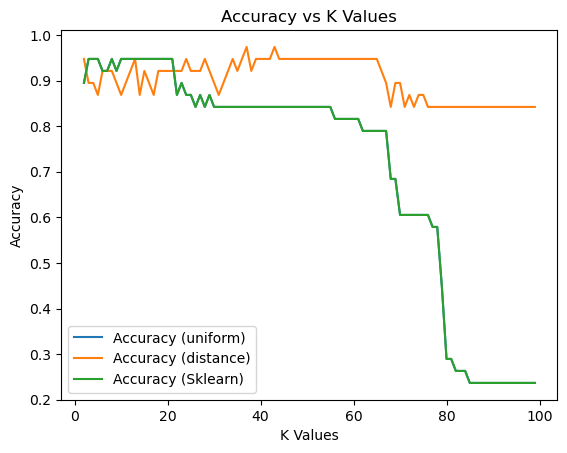

In [7]:
plt.plot(range(2, 100), uniform_acc, label="Accuracy (uniform)")
plt.plot(range(2, 100), distance_acc, label="Accuracy (distance)")
plt.plot(range(2, 100), sk_acc, label="Accuracy (Sklearn)")

plt.title('Accuracy vs K Values')
plt.xlabel('K Values')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Resultados
Tomando valores de K del 2 al 100 y graficando K vr. precision, la implementación de distancia propia tiene mejores resultados que los de la biblioteca SKlearn para aquellos valores de K mayores de 20, mientras que en el caso de valores menores a 20, la precision varia mucho, tendiendo a ser menor o igual que la obtenida con SKlearn. Para la implementacion uniforme, los resultados de ambas implementaciones (uniforme y SKlearn) arrojan los mismos resultados. 

Con ayuda de la grafica anterior podemos concluir que para valores elevados de K, la implementacion de distancia tiende a tener un resultado mejor que la uniforme, manteniendose entre un 85%-95% de presicion, por lo que se recomienda utilizar una implementacion de distancia si se tienen valores elevados de vecinos (K), mientras que para valores K mas bajos se recomienda utilizar la implementacion uniforme.


## 2) Clasificador de Múltiples Clases

In [28]:
import numpy as np
import sys

from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
digits = load_digits(n_class=10, as_frame=True)

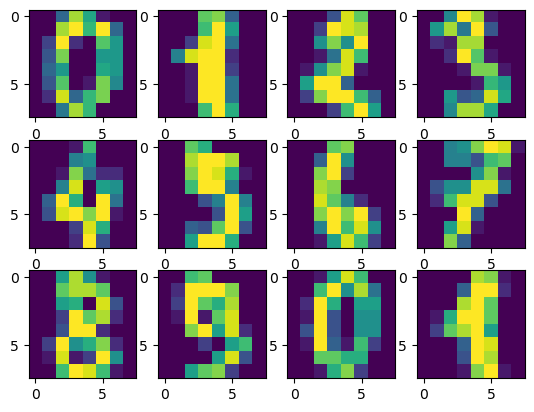

In [29]:
for i in range(1,13):
    plt.subplot(3, 4, i)
    plt.imshow(digits.images[i-1])

In [30]:
dimentions = digits.data.shape

import pandas as pd
pd.DataFrame([dimentions],
             ['Numbers'],    
             ['Data', 'Features'])

,Data,Features
Numbers,1797,64


In [54]:
training_data = digits.data
y = digits.target

In [55]:
# Standardizing training data
mu = np.mean(training_data, 0)
sigma = np.std(training_data, 0)

training_data = (training_data - mu ) / sigma

# Reparing NaN values
for pixel in training_data:
    for index, value in enumerate(training_data[pixel]):
        if np.isnan(value):
            training_data[pixel][index] = 0
        else:
            break

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

In [57]:
class KNearestNeighborsDigits():
    def __init__(self, X_train, y_train, n_neighbors=5, weights='uniform'):

        self.X_train = X_train
        self.y_train = y_train

        self.n_neighbors = n_neighbors
        self.weights = weights

        self.n_classes = 10

    def euclidian_distance(self, a, b):
        return np.sqrt(np.sum((a - b)**2, axis=1))

    def kneighbors(self, X_test, return_distance=False):

        dist = []
        neigh_ind = []
        point_dist = []
        
        for x_test in X_test:
            point_dist += [ self.euclidian_distance(x_test, self.X_train) ]

        for row in point_dist:
            enum_neigh = enumerate(row)
            sorted_neigh = sorted(enum_neigh,
                                  key=lambda x: x[1])[:self.n_neighbors]

            ind_list = [tup[0] for tup in sorted_neigh]
            dist_list = [tup[1] for tup in sorted_neigh]

            dist.append(dist_list)
            neigh_ind.append(ind_list)

        if return_distance:
            return np.array(dist), np.array(neigh_ind)

        return np.array(neigh_ind)

    def predict(self, X_test):

        if self.weights == 'uniform':
            neighbors = self.kneighbors(X_test)
            y_pred = np.array([
                np.argmax(np.bincount(self.y_train[neighbor]))
                for neighbor in neighbors
            ])
            return y_pred

        if self.weights == 'distance':
            dists, neighbors = self.kneighbors(X_test, return_distance=True)
            y_results = []
            y_pred = []
            
            for i, neighbor in enumerate(neighbors):
                y_results += [(self.y_train[neighbor], dists[i])]
                
            for y_tag, dist in y_results:
                y_class_dist = []
                for j in range(self.n_classes):
                    dist_array = np.where(y_tag == j, dist, 0)
                    if np.count_nonzero(dist_array) == 0:
                        mean_dist = sys.maxsize
                    else:
                        mean_dist = np.sum(dist_array) / np.count_nonzero(dist_array)
                    y_class_dist.append(mean_dist)
                y_pred.append(np.argmin(y_class_dist))

            return y_pred

    def score(self, X_test, y_test):
        y_pred = self.predict(X_test)
        return float(sum(y_pred == y_test)) / float(len(y_test)), y_pred, y_test


In [64]:
k_values = [2,3,5,7,8,10,11]

if isinstance(training_data, pd.DataFrame):
    training_data = training_data.to_numpy()
    y = y.to_numpy()

X_train, X_test, y_train, y_test = train_test_split(\
                training_data, y, test_size=0.25, random_state=45)

accuracy_values = []

for i in k_values:

    normal_classifier = KNearestNeighborsDigits(X_train, y_train, n_neighbors=i)
    our_classifier = KNearestNeighborsDigits(X_train, y_train, n_neighbors=i, weights='distance')
    sklearn_classifier = KNeighborsClassifier(n_neighbors=i).fit(X_train, y_train)
    
    normal_accuracy = normal_classifier.score(X_test, y_test)[0]
    our_accuracy = our_classifier.score(X_test, y_test)[0]    
    sklearn_accuracy = sklearn_classifier.score(X_test, y_test)

    accuracy_values.append([normal_accuracy, our_accuracy, sklearn_accuracy])
        
pd.DataFrame(accuracy_values,
             [("K="+ str(k)) for k in k_values],    
             ['Accuracy (Normal)','Accuracy (Ours)', 'Accuracy (Sklearn)'])

[[ 0.         -0.33501649 -0.67419451 ... -0.12952258 -0.5056698
  -0.19600752]
 [ 0.         -0.33501649 -1.09493684 ...  1.39616473  3.16234137
  -0.19600752]
 [ 0.         -0.33501649 -0.88456568 ... -1.14664746 -0.5056698
  -0.19600752]
 ...
 [ 0.         -0.33501649 -1.09493684 ... -0.97712664 -0.5056698
  -0.19600752]
 [ 0.         -0.33501649 -0.25345218 ... -0.46856421 -0.5056698
  -0.19600752]
 [ 0.         -0.33501649 -0.25345218 ... -0.80760583 -0.5056698
  -0.19600752]]
[[ 0.         -0.33501649 -0.67419451 ... -0.12952258 -0.5056698
  -0.19600752]
 [ 0.         -0.33501649 -1.09493684 ...  1.39616473  3.16234137
  -0.19600752]
 [ 0.         -0.33501649 -0.88456568 ... -1.14664746 -0.5056698
  -0.19600752]
 ...
 [ 0.         -0.33501649 -1.09493684 ... -0.97712664 -0.5056698
  -0.19600752]
 [ 0.         -0.33501649 -0.25345218 ... -0.46856421 -0.5056698
  -0.19600752]
 [ 0.         -0.33501649 -0.25345218 ... -0.80760583 -0.5056698
  -0.19600752]]
[[ 0.         -0.33501649 

,Accuracy (Normal),Accuracy (Ours),Accuracy (Sklearn)
K=2,0.964444,0.971111,0.964444
K=3,0.977778,0.971111,0.977778
K=5,0.964444,0.966667,0.964444
K=7,0.960000,0.962222,0.960000
K=8,0.960000,0.953333,0.960000
K=10,0.957778,0.953333,0.957778
K=11,0.951111,0.951111,0.951111


In [38]:
accuracy_values = []

for i in range(2, 100, 4): 
    normal_classifier = KNearestNeighborsDigits(X_train, y_train, n_neighbors=i)
    our_classifier = KNearestNeighborsDigits(X_train, y_train, n_neighbors=i, weights='distance')
    sklearn_classifier = KNeighborsClassifier(n_neighbors=i).fit(X_train, y_train)
    
    normal_accuracy = normal_classifier.score(X_test, y_test)[0]
    our_accuracy = our_classifier.score(X_test, y_test)[0]
    sklearn_accuracy = sklearn_classifier.score(X_test, y_test)

    accuracy_values.append([normal_accuracy, our_accuracy, sklearn_accuracy])

normal_acc = [acc[0] for acc in accuracy_values]
our_acc = [acc[1] for acc in accuracy_values]
sk_acc = [acc[2] for acc in accuracy_values]

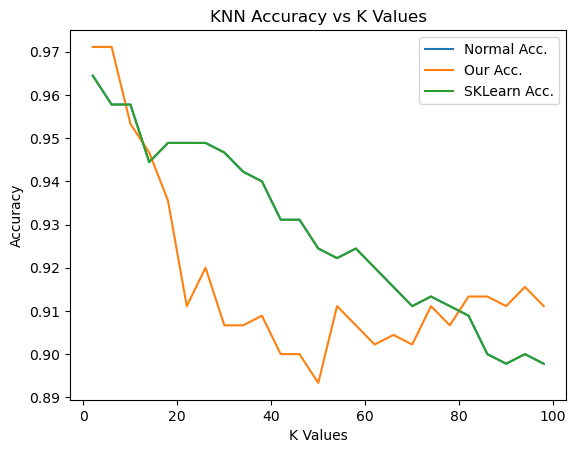

In [40]:
plt.plot(range(2, 100, 4), normal_acc, label="Normal Acc.")
plt.plot(range(2, 100, 4), our_acc, label="Our Acc.")
plt.plot(range(2, 100, 4), sk_acc, label="SKLearn Acc.")

plt.title('KNN Accuracy vs K Values')
plt.xlabel('K Values')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Resultados
Los resultados de la clasificacion de las imagenes indican que para los valores de K solicitados, la implementación de distancia propia tiene mejores resultados que los de la biblioteca SKLearn, y también que los de la implementación normal de distancia para los valores de K más pequeños. Sin embargo, conforme crece el valor de K, la precisión se va volviendo progresivamente similar, hasta los valores más altos donde cae por debajo de la de SKLearn, con excepción de K=11.
Adicional a lo solicitado, se adjunta una gráfica para demostrar la caída en la precisión de las implementaciones conforme aumenta el valor de K, para valores entre 2 y 100, con saltos de 4 unidades. En esta se puede apreciar cómo el valor de la precisión supera al de SKLearn para valores de K aproximadamente menores que 10. A partir de ese valor, SKLearn tiene una mayor precisión hasta alcanzar el valor de K=80, donde la implementación propia recupera precisión y supera a la de SKLearn.

In [67]:
import json

our_predictions = [0,1,2,3,5]

In [70]:
with open("./images/image_data.json", "r") as json_file:
    my_dict = json.load(json_file)
    
our_dataframe = pd.DataFrame(my_dict)

# Standardizing our data
mu = np.mean(our_dataframe, 0)
sigma = np.std(our_dataframe, 0)

our_dataframe = (our_dataframe - mu ) / sigma


# Reparing NaN values
for pixel in our_dataframe:
    for index, value in enumerate(our_dataframe[pixel]):
        if np.isnan(value):
            our_dataframe[pixel][index] = 0
        else:
            break

our_dataframe.head(10)

,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,pixel_1_1,...,pixel_6_6,pixel_6_7,pixel_7_0,pixel_7_1,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7
0,0.0,0.0,-0.5,-0.680724,-0.582583,-0.827175,-0.5,-0.816497,-0.5,-0.5,...,0.085813,-0.253038,-0.5,-0.304445,-0.644509,-1.478668,-1.260757,-0.758501,0.0,-0.5
1,0.0,0.0,-0.5,1.894188,1.981683,1.372759,-0.5,-0.816497,-0.5,-0.5,...,-0.925553,-0.577051,-0.5,-1.122639,-1.193027,0.512556,-0.284939,-0.758501,0.0,-0.5
2,0.0,0.0,2.0,0.147983,-0.233933,-0.827175,-0.5,-0.816497,2.0,2.0,...,1.817395,1.984190,2.0,1.712500,1.772399,1.471293,1.588632,1.723016,0.0,2.0
3,0.0,0.0,-0.5,-0.680724,-0.582583,1.064768,2.0,1.224745,-0.5,-0.5,...,-0.067424,-0.577051,-0.5,-0.723056,-0.061708,0.106936,0.612814,0.552489,0.0,-0.5
4,0.0,0.0,-0.5,-0.680724,-0.582583,-0.783176,-0.5,1.224745,-0.5,-0.5,...,-0.910230,-0.577051,-0.5,0.437639,0.126845,-0.612117,-0.655750,-0.758501,0.0,-0.5


In [75]:
k_values = [2,3,5,7,8,10,11]

if isinstance(our_dataframe, pd.DataFrame):
    our_dataframe = our_dataframe.to_numpy()
    
X_train, X_test, y_train, y_test = train_test_split(\
                training_data, y, test_size=0.25, random_state=45)

accuracy_values = []

for i in k_values:

    normal_classifier = KNearestNeighborsDigits(X_train, y_train, n_neighbors=i)
    our_classifier = KNearestNeighborsDigits(X_train, y_train, n_neighbors=i, weights='distance')
    sklearn_classifier = KNeighborsClassifier(n_neighbors=i).fit(X_train, y_train)
    
    normal_accuracy = normal_classifier.score(our_dataframe, our_predictions)[0]
    our_accuracy = our_classifier.score(our_dataframe, our_predictions)[0]
    sklearn_accuracy = sklearn_classifier.score(our_dataframe, our_predictions)

    accuracy_values.append([normal_accuracy, our_accuracy, sklearn_accuracy])
        
pd.DataFrame(accuracy_values,
             [("K="+ str(k)) for k in k_values],    
             ['Accuracy (Normal)','Accuracy (Ours)', 'Accuracy (Sklearn)'])

TypeError: 'bool' object is not iterable